In [1]:
import pandas as pd

In [3]:
import nltk
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------


Downloader>  q


True

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

ModuleNotFoundError: No module named 'matplotlib'

In [5]:
message = pd.read_csv('smsspamcollection/SMSSpamCollection', sep='\t',
                           names=["label", "message"])
message.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
message.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [7]:
message['length'] = message['message'].apply(len)
message.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [8]:
message['length'].plot(bins=50, kind='hist') 

ModuleNotFoundError: No module named 'matplotlib'

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f922d1151d0>,
      dtype=object)

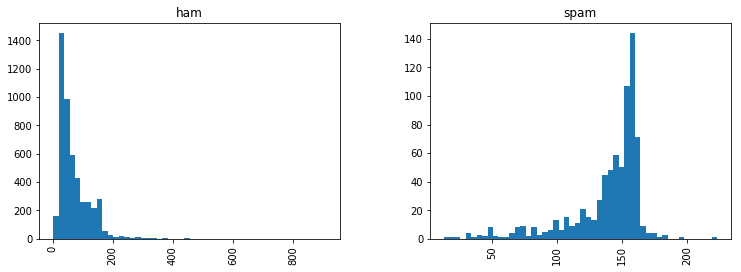

In [8]:
message.hist(column='length', by='label', bins=50,figsize=(12,4))

In [9]:
import string

In [10]:
def text_process(mess):
    nopunc = [char for char in mess if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [11]:
message.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

In [15]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(message['message'])

In [22]:
print(len(bow_transformer.vocabulary_))

11425


In [26]:
bow4 = bow_transformer.transform([message4])
print(bow4)
print(bow4.shape)

  (0, 4068)	2
  (0, 4629)	1
  (0, 5261)	1
  (0, 6204)	1
  (0, 6222)	1
  (0, 7186)	1
  (0, 9554)	2
(1, 11425)


In [25]:
message4 = message['message'][3]
print(message4)

U dun say so early hor... U c already then say...


In [18]:
messages_bow = bow_transformer.transform(message['message'])

In [19]:
sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print('sparsity: {}'.format(sparsity))

sparsity: 0.07940295412668218


In [27]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 9554)	0.5385626262927564
  (0, 7186)	0.4389365653379857
  (0, 6222)	0.3187216892949149
  (0, 6204)	0.29953799723697416
  (0, 5261)	0.29729957405868723
  (0, 4629)	0.26619801906087187
  (0, 4068)	0.40832589933384067


In [28]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['u']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['university']])

3.2800524267409408
8.527076498901426


In [30]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(5572, 11425)


In [32]:
from sklearn.naive_bayes import MultinomialNB
spam_detect_model = MultinomialNB().fit(messages_tfidf, message['label'])

In [34]:
print('predicted:', spam_detect_model.predict(tfidf4)[0])
print('expected:', message.label[3])

predicted: ham
expected: ham


In [35]:
all_predictions = spam_detect_model.predict(messages_tfidf)
print(all_predictions)

['ham' 'ham' 'spam' ... 'ham' 'ham' 'ham']


In [37]:
from sklearn.metrics import classification_report
print (classification_report(message['label'], all_predictions))

             precision    recall  f1-score   support

        ham       0.98      1.00      0.99      4825
       spam       1.00      0.85      0.92       747

avg / total       0.98      0.98      0.98      5572



In [39]:
from sklearn.model_selection import train_test_split

msg_train, msg_test, label_train, label_test = \
train_test_split(message['message'], message['label'], test_size=0.2)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

4457 1115 5572


In [40]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [41]:
pipeline.fit(msg_train,label_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function text_process at 0x7f21cf3e4378>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=No...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [42]:
predictions = pipeline.predict(msg_test)

In [43]:
print(classification_report(predictions,label_test))

             precision    recall  f1-score   support

        ham       1.00      0.95      0.97       993
       spam       0.71      1.00      0.83       122

avg / total       0.97      0.96      0.96      1115

